<center><h1>Support Vector Machine (Машина Опорных Векторов)</h1></center>

## Содержание

1. [Описание датасета](#dataset)
2. [Вычисления из лекционного ноутбука](#lection)
3. [Применение svc к датасету](#svc)
4. [Вывод](#Conclusion)


<a id='dataset'></a>

## 1. Описание датасета

**[DataSet](https://archive.ics.uci.edu/ml/datasets/seeds) Information**

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

The data set can be used for the tasks of classification and cluster analysis.


**Attribute Information**

To construct the data, seven geometric parameters of wheat kernels were measured:
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.
All of these parameters were real-valued continuous.

<a id='lection'></a>

## 2. Вычисления из лекционного ноутбука

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from sklearn.datasets import make_classification, make_circles
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

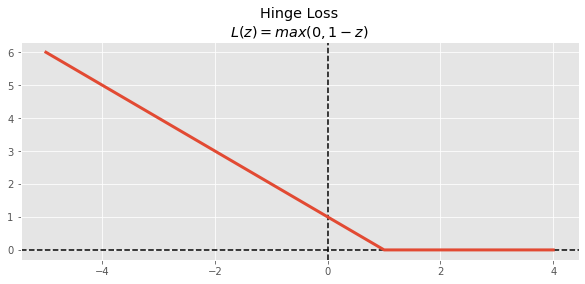

In [2]:
def HingeLoss(z):
    return max([0, 1 - z])

x = np.arange(-5, 5, 1)
y = [HingeLoss(v) for v in x]

plt.figure(figsize=(10,4))
plt.axvline(0, color='black', linestyle="--")
plt.axhline(0, color='black', linestyle="--")
plt.title("Hinge Loss\n$L(z)=max(0, 1-z)$")
plt.plot(x, y, linewidth=3)
plt.show()

In [3]:
data = pd.read_csv('seeds_dataset.txt', header=None, sep='\t', names=["area", "perimeter", "compactness", "kernel_length", 
                "kernel_width", "asymmetry_coef", "groove_length", "class"])
data = data.dropna()

In [6]:
X = data.drop(columns="class")
X_numpy = X.to_numpy()
y = data['class']
y_numpy = y.to_numpy()

In [7]:
y.value_counts()

3    70
2    70
1    70
Name: class, dtype: int64

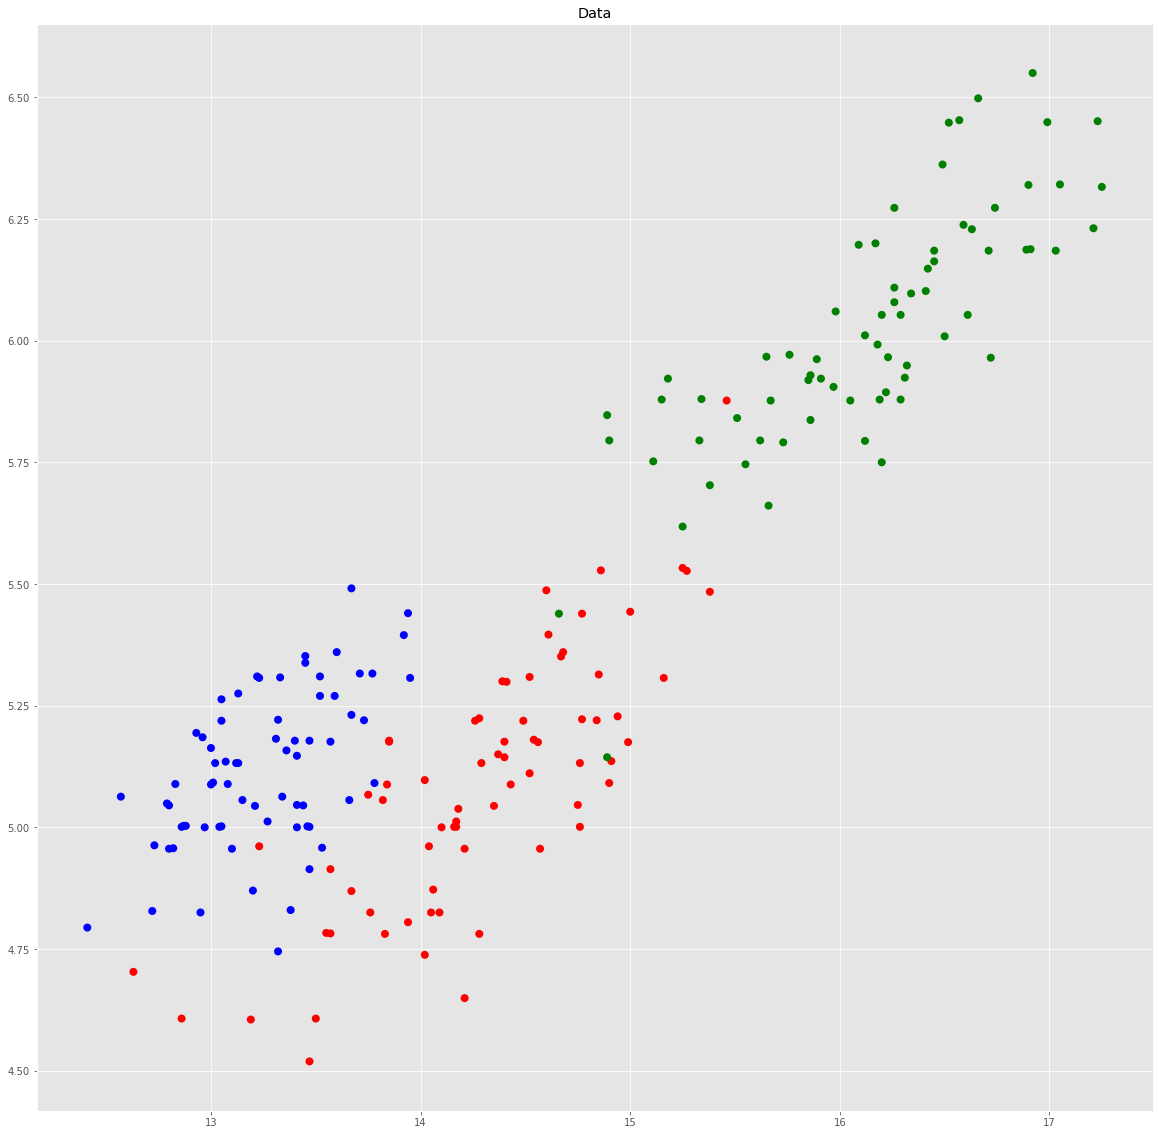

In [15]:
plt.figure(figsize=(20,20))
plt.title("Data")
plt.scatter(X_numpy[:,1], X_numpy[:,6], linewidths=2, 
            c=["red" if col==1 else "green" if col == 2 else "blue" for col in y_numpy])
plt.show()

In [16]:
def svm_sgd(X, Y):
    w = np.random.normal(size=len(X[0]))
    lr = 0.1
    n_epochs = 100000
    C = 10000
    
    for epoch in tqdm_notebook(range(1, n_epochs + 1)): # 1 эпоха - проход по всем данным 
        for i, x in enumerate(X):                  # 1 итерация (в данном случае) - рассчет градиента для 1 точки
            
            # HingeLoss = max(0, y[i] x[i] w)
            HL = Y[i] * np.dot(X[i], w) # Hinge Loss - часть максимума, кторая больше 0

            if HL < 1:
                w = w - lr * (1/epoch) * (w - C * X[i] * Y[i])
            else:
                w = w - lr * (1/epoch) * w
    
    return w

In [18]:
w = svm_sgd(X_numpy, y_numpy)

In [19]:
x_hyp = np.arange(0,20)
y_hyp = -(x_hyp * w[1] + w[0]) / w[2]

left_margin_y = (-1 - x_hyp * w[1] - w[0]) / w[2]
right_margin_y = (1 - x_hyp * w[1] - w[0]) / w[2]

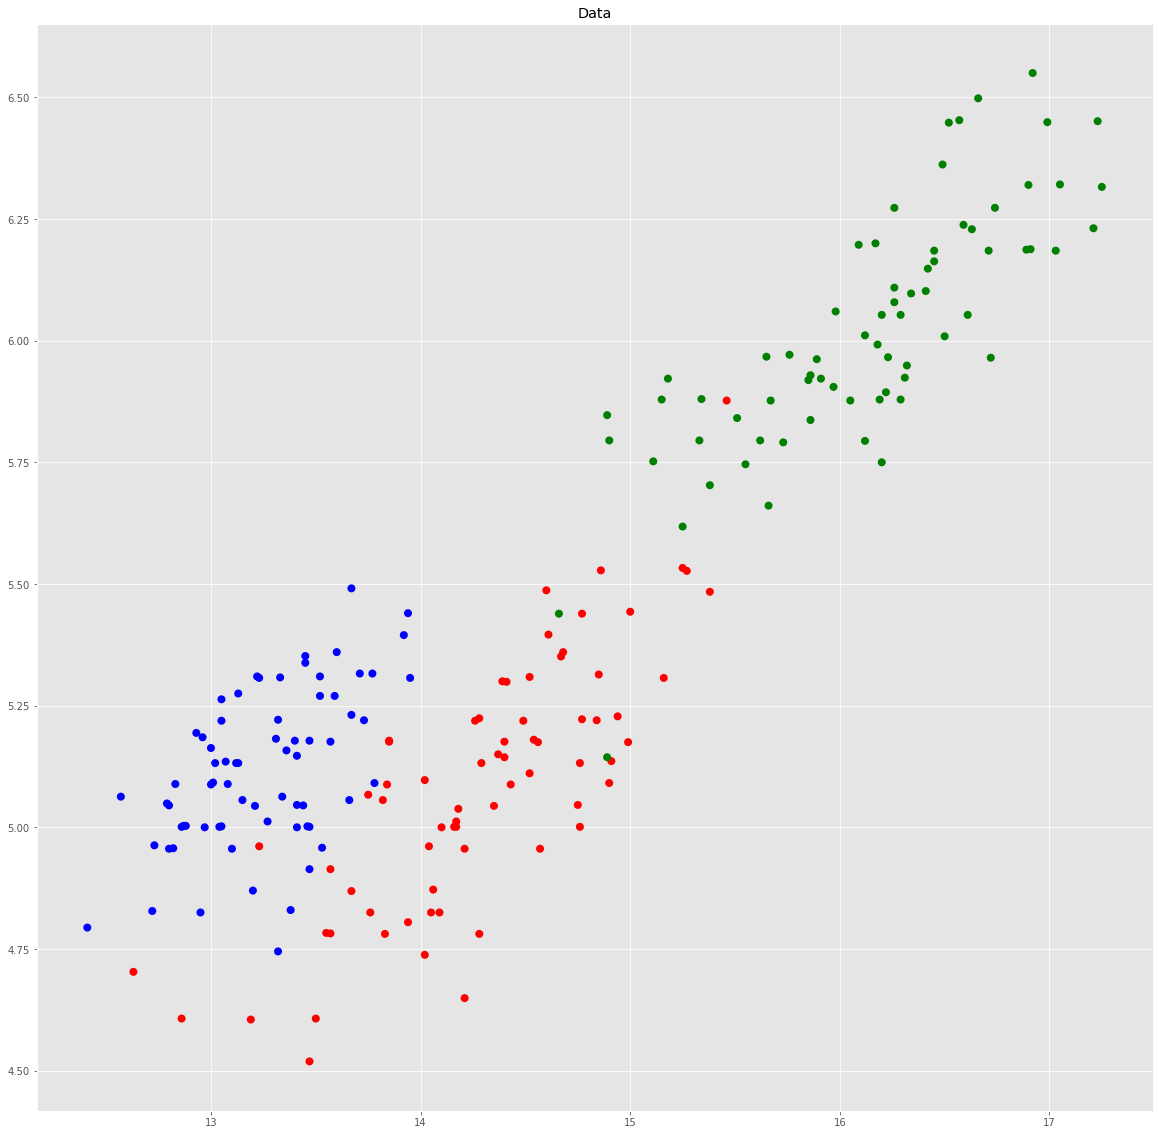

In [20]:
plt.figure(figsize=(20,20))
plt.title("Data")
plt.scatter(X_numpy[:,1], X_numpy[:,6], linewidths=2, 
            c=["red" if col==1 else "green" if col == 2 else "blue" for col in y_numpy])
plt.show()

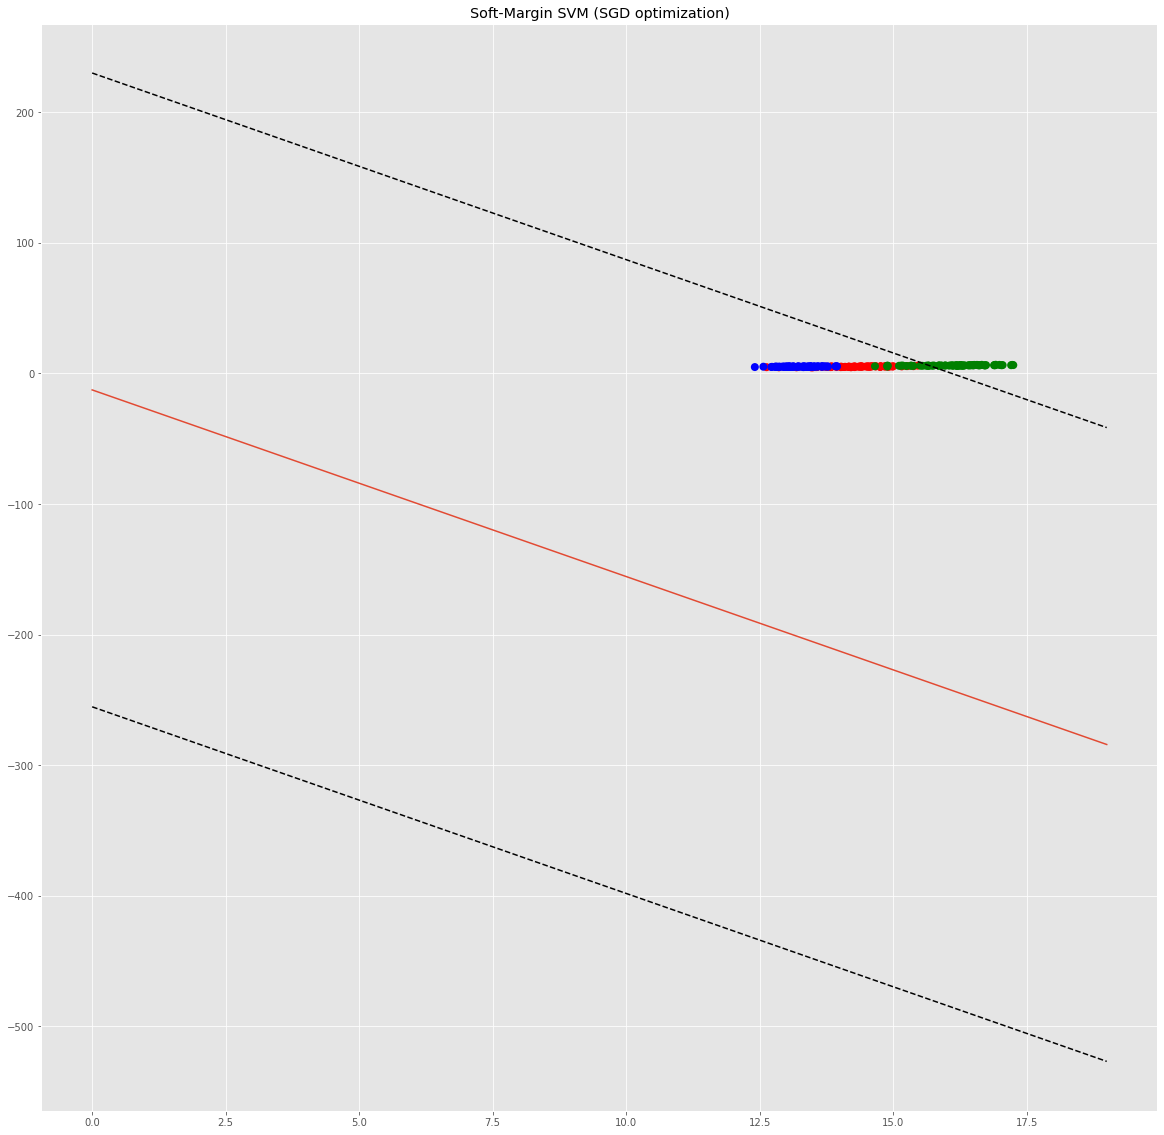

In [21]:
plt.figure(figsize=(20,20))
plt.title("Soft-Margin SVM (SGD optimization)")
plt.scatter(X_numpy[:,1], X_numpy[:,6], linewidths=2, 
            c=["red" if col==1 else  "green" if col == 2 else "blue" for col in y_numpy])

plt.plot(x_hyp, y_hyp)
plt.plot(x_hyp, left_margin_y, color='black', linestyle="--")
plt.plot(x_hyp, right_margin_y, color='black', linestyle="--")
plt.show()

### Посмотрим реализацию scikit - learn:

In [30]:
def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    cplot = ax.contour(XX, YY, P1, colors='k',# label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    
    ax.contour(XX, YY, P2, colors='r',# label='logreg',
               levels=[0], alpha=0.5,
               linestyles=['-'])

    
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    cplot = ax.contour(XX, YY, P1, colors='k',# label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)

ValueError: cannot reshape array of size 2700 into shape (30,30)

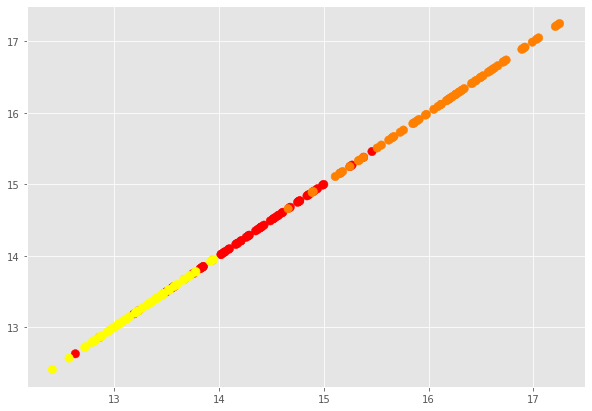

In [31]:
lin_svm = svm.SVC(kernel='linear', C=1).fit(X[["perimeter", "groove_length"]], y)
log_reg = LogisticRegression(C=1).fit(X[["perimeter", "groove_length"]], y)
    
plt.figure(figsize=(10,7))
plt.scatter(X_numpy[:, 1], X_numpy[:, 1], c=y_numpy, s=70, cmap='autumn')
    
plot_svc_log_decision_function(lin_svm, log_reg)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

In [32]:
def lin_sep_svm_demo_kernel_C(X, y, class_sep=2, kernel='linear', random_state=31, 
                              C = 1, gamma=1.2, degree=2, coef0=0.0):
    #X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                #n_redundant=0, n_clusters_per_class=1, random_state=31)

    lin_svm = svm.SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(lin_svm)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

ValueError: cannot reshape array of size 2700 into shape (30,30)

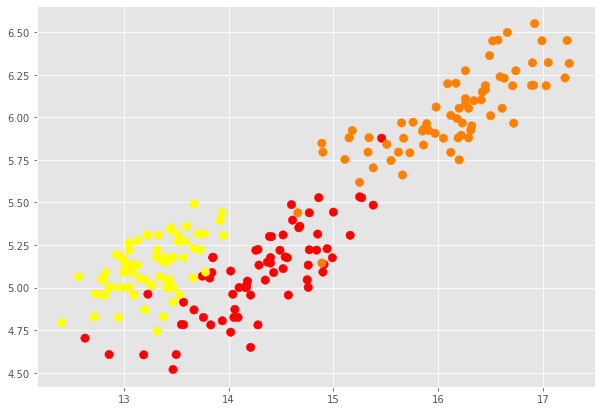

In [34]:
lin_sep_svm_demo_kernel_C(X_numpy[:, [1, 6]], y_numpy, kernel='poly')

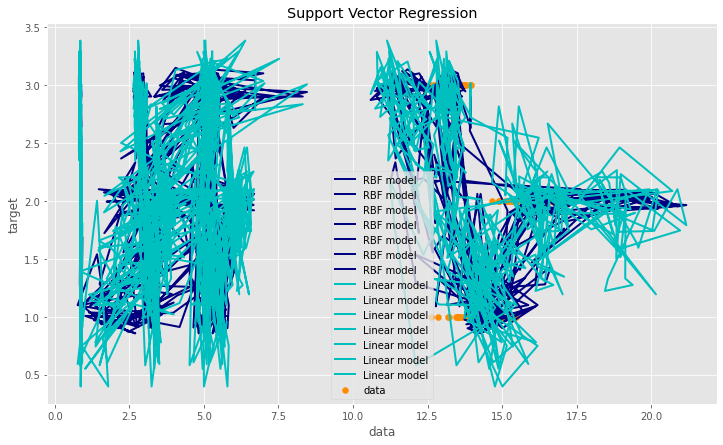

In [35]:
#X = np.sort(5 * np.random.rand(200, 1), axis=0)
#y = np.sin(X).ravel()
#y[::5] += 3 * (0.5 - np.random.rand(40))

svr_rbf = svm.SVR(kernel='rbf')#, C=1e3, gamma=0.1)
svr_lin = svm.SVR(kernel='linear')#, C=1e3)
svr_poly = svm.SVR(kernel='poly')#, C=1e3, degree=3)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

lw = 2
plt.figure(figsize=(12, 7))
plt.scatter(X_numpy[:,1], y_numpy, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
#plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

<a id='svc'></a>

## 3. Применение svc к датасету

In [36]:
data = pd.read_csv('seeds_dataset.txt', header=None, sep='\t', names=["area", "perimeter", "compactness", "kernel_length", 
                "kernel_width", "asymmetry_coef", "groove_length", "class"])
data = data.dropna()

In [37]:
data.head()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coef,groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [38]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision micro: \t {:.3f}\n" +\
                "Precision macro: \t {:.3f}\n" +\
                 "Recall micro: \t {:.3f}\n" +\
                "Recall macro: \t {:.3f}\n" +\
                 "f1_score micro: \t {:.3f}\n" +\
                "f1_score macro: \t {:.3f}\n"
    
    acc = accuracy_score(prediction, actual)
    precision_micro = precision_score(prediction, actual, average='micro')
    precision_macro = precision_score(prediction, actual, average='macro')
    recall_micro = recall_score(prediction, actual, average='micro')
    recall_macro = recall_score(prediction, actual, average='macro')
    f1_micro = f1_score(prediction, actual, average='micro')
    f1_macro = f1_score(prediction, actual, average='macro')    
    
    quality_list = [acc, precision_micro, precision_macro, recall_micro, recall_macro, f1_micro, f1_macro]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual, average='micro'),
            precision_score(prediction, actual, average='macro'),
            recall_score(prediction, actual, average='micro'),
            recall_score(prediction, actual, average='macro'),
            f1_score(prediction, actual, average='micro'),
            f1_score(prediction, actual, average='macro')
        ))
        print("======================\n")
    
    return quality_list

In [39]:
data.describe()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coef,groove_length,class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['class'], axis=1),
    data['class'],
    test_size=0.3,
    stratify=data['class'],
    random_state=0)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
model_LogR = LogisticRegression()
model_LogR.fit(X_train_scaled, y_train)
pred_LR = model_LogR.predict(X_test_scaled)

In [42]:
qr_lr = quality_report(pred_LR, y_test.values)


=== Quality Report ===
Accuracy: 	 0.889
Precision micro: 	 0.889
Precision macro: 	 0.889
Recall micro: 	 0.889
Recall macro: 	 0.894
f1_score micro: 	 0.889
f1_score macro: 	 0.884




In [48]:
def get_svc(X_train_scaled, X_test_scaled, y_train, y_test, kernel):
    model_svc = svm.SVC(kernel = kernel)
    model_svc.fit(X_train_scaled, y_train)
    pred_svc = model_svc.predict(X_test_scaled)
    print(kernel)
    qr_svc = quality_report(pred_svc, y_test.values)

In [49]:
get_svc(X_train_scaled, X_test_scaled, y_train, y_test, 'linear')
get_svc(X_train_scaled, X_test_scaled, y_train, y_test, 'poly')
get_svc(X_train_scaled, X_test_scaled, y_train, y_test, 'rbf')
get_svc(X_train_scaled, X_test_scaled, y_train, y_test, 'sigmoid')

linear

=== Quality Report ===
Accuracy: 	 0.905
Precision micro: 	 0.905
Precision macro: 	 0.905
Recall micro: 	 0.905
Recall macro: 	 0.905
f1_score micro: 	 0.905
f1_score macro: 	 0.905


poly

=== Quality Report ===
Accuracy: 	 0.746
Precision micro: 	 0.746
Precision macro: 	 0.746
Recall micro: 	 0.746
Recall macro: 	 0.774
f1_score micro: 	 0.746
f1_score macro: 	 0.738


rbf

=== Quality Report ===
Accuracy: 	 0.905
Precision micro: 	 0.905
Precision macro: 	 0.905
Recall micro: 	 0.905
Recall macro: 	 0.905
f1_score micro: 	 0.905
f1_score macro: 	 0.905


sigmoid

=== Quality Report ===
Accuracy: 	 0.873
Precision micro: 	 0.873
Precision macro: 	 0.873
Recall micro: 	 0.873
Recall macro: 	 0.872
f1_score micro: 	 0.873
f1_score macro: 	 0.871




<a id='Conclusion'></a>

## 4. Вывод 

На нашем датасете svc алгоритм показал результаты лучше, чем логистическая регрессия. Оптимальные ядра для нашего датасета - linear, rbf.